# Flight Departure Delay Prediction

In [2]:
# """
# # Flight Departure Delay Prediction
# ## Objective: Predict flight departure delays (DEP_DEL15) based on historical flight data and other influencing factors

# This project analyzes flight data to build a machine learning model that predicts whether a flight's departure will be delayed by 15 minutes or more.
# """

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import xgboost as xgb
import shap
import warnings
import time
import os
from datetime import datetime
from matplotlib.colors import ListedColormap

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

/Users/alibaalam/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Create a directory for saving visualizations
viz_dir = 'visualizations'
if not os.path.exists(viz_dir):
    os.makedirs(viz_dir)
    print(f"Created directory: {viz_dir}")
else:
    print(f"Directory already exists: {viz_dir}")

# Function to save visualization with proper naming
def save_visualization(plt, filename, dpi=300):
    full_path = os.path.join(viz_dir, f"{filename}.png")
    plt.savefig(full_path, dpi=dpi, bbox_inches='tight')
    print(f"Saved visualization: {full_path}")

Directory already exists: visualizations


In [5]:
# Load the dataset
print("Loading dataset...")
start_time = time.time()
df = pd.read_csv('data/Jan_2019_ontime.csv') # Update path if necessary
print(f"Dataset loaded in {time.time() - start_time:.2f} seconds")
print(f"Dataset shape: {df.shape}")

Loading dataset...
Dataset loaded in 0.86 seconds
Dataset shape: (583985, 22)


In [6]:
# Initial data exploration
print("\nFirst 5 rows of the dataset:")
print(df.head())


First 5 rows of the dataset:
   DAY_OF_MONTH  DAY_OF_WEEK OP_UNIQUE_CARRIER  OP_CARRIER_AIRLINE_ID  \
0             1            2                9E                  20363   
1             1            2                9E                  20363   
2             1            2                9E                  20363   
3             1            2                9E                  20363   
4             1            2                9E                  20363   

  OP_CARRIER TAIL_NUM  OP_CARRIER_FL_NUM  ORIGIN_AIRPORT_ID  \
0         9E   N8688C               3280              11953   
1         9E   N348PQ               3281              13487   
2         9E   N8896A               3282              11433   
3         9E   N8886A               3283              15249   
4         9E   N8974C               3284              10397   

   ORIGIN_AIRPORT_SEQ_ID ORIGIN  ...  DEST  DEP_TIME DEP_DEL15  DEP_TIME_BLK  \
0                1195302    GNV  ...   ATL     601.0       0.0     0600-

In [7]:
print("\nData types:")
print(df.dtypes)


Data types:
DAY_OF_MONTH               int64
DAY_OF_WEEK                int64
OP_UNIQUE_CARRIER         object
OP_CARRIER_AIRLINE_ID      int64
OP_CARRIER                object
TAIL_NUM                  object
OP_CARRIER_FL_NUM          int64
ORIGIN_AIRPORT_ID          int64
ORIGIN_AIRPORT_SEQ_ID      int64
ORIGIN                    object
DEST_AIRPORT_ID            int64
DEST_AIRPORT_SEQ_ID        int64
DEST                      object
DEP_TIME                 float64
DEP_DEL15                float64
DEP_TIME_BLK              object
ARR_TIME                 float64
ARR_DEL15                float64
CANCELLED                float64
DIVERTED                 float64
DISTANCE                 float64
Unnamed: 21              float64
dtype: object


In [8]:
print("\nSummary statistics:")
print(df.describe())


Summary statistics:
        DAY_OF_MONTH    DAY_OF_WEEK  OP_CARRIER_AIRLINE_ID  OP_CARRIER_FL_NUM  \
count  583985.000000  583985.000000          583985.000000      583985.000000   
mean       15.960088       3.835626           19983.213168        2537.869334   
std         8.987942       1.921899             377.724638        1821.736145   
min         1.000000       1.000000           19393.000000           1.000000   
25%         8.000000       2.000000           19790.000000         979.000000   
50%        16.000000       4.000000           19977.000000        2114.000000   
75%        24.000000       5.000000           20368.000000        3902.000000   
max        31.000000       7.000000           20452.000000        7439.000000   

       ORIGIN_AIRPORT_ID  ORIGIN_AIRPORT_SEQ_ID  DEST_AIRPORT_ID  \
count      583985.000000           5.839850e+05    583985.000000   
mean        12659.701982           1.265974e+06     12659.470015   
std          1519.405493           1.519403e+

In [9]:
print("\nChecking for missing values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Checking for missing values:
TAIL_NUM         2543
DEP_TIME        16352
DEP_DEL15       16355
ARR_TIME        17061
ARR_DEL15       18022
Unnamed: 21    583985
dtype: int64


In [10]:
# Check the distribution of target variable
print("\nTarget variable distribution:")
target_dist = df['DEP_DEL15'].value_counts(normalize=True)
print(target_dist)


Target variable distribution:
DEP_DEL15
0.0    0.825719
1.0    0.174281
Name: proportion, dtype: float64


([<matplotlib.axis.XTick at 0x1242b8b00>,
 [Text(0, 0, 'No Delay (0)'), Text(1, 0, 'Delayed (1)')])

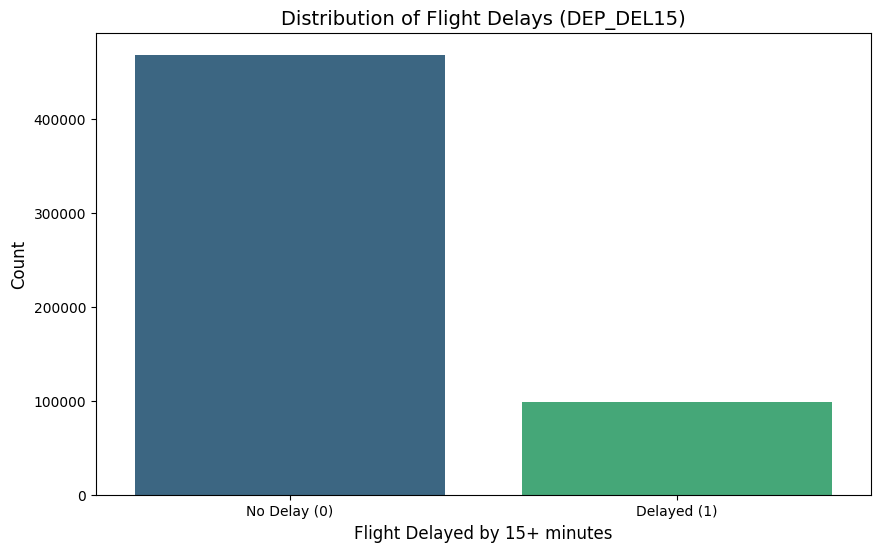

In [11]:
# Visualize target distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='DEP_DEL15', data=df, palette='viridis')
plt.title('Distribution of Flight Delays (DEP_DEL15)', fontsize=14)
plt.xlabel('Flight Delayed by 15+ minutes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['No Delay (0)', 'Delayed (1)'])

In [12]:
# Add count and percentage labels to the bars
total = len(df['DEP_DEL15'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.1,
            f'{height} ({height/total:.1%})',
            ha="center", fontsize=12)

plt.tight_layout()
save_visualization(plt, '01_target_distribution')
plt.show()

Saved visualization: visualizations/01_target_distribution.png


<Figure size 640x480 with 0 Axes>

In [13]:
# Data preprocessing
print("\nStarting data preprocessing...")
start_time = time.time()


Starting data preprocessing...


In [14]:
# Copy of the dataframe
df_cleaned = df.copy()

In [15]:
# Drop the empty column
if 'Unnamed: 21' in df_cleaned.columns:
    df_cleaned.drop('Unnamed: 21', axis=1, inplace=True)

In [16]:
# Handle missing values
for column in df_cleaned.columns:
    if df_cleaned[column].dtype == 'object':
        df_cleaned[column].fillna('Unknown', inplace=True)
    else:
        df_cleaned[column].fillna(df_cleaned[column].median(), inplace=True)

In [17]:
# Convert time features to more usable formats
def format_time(time_value):
    if pd.isna(time_value):
        return np.nan
    
    time_str = str(int(time_value))
    if len(time_str) < 4:
        time_str = '0' * (4 - len(time_str)) + time_str
    
    hour = int(time_str[:2]) if len(time_str) >= 2 else 0
    minute = int(time_str[2:]) if len(time_str) >= 4 else 0
    
    # Convert to minutes since midnight
    return hour * 60 + minute

In [18]:
# Apply time conversion for DEP_TIME and ARR_TIME

if 'DEP_TIME' in df_cleaned.columns:
    df_cleaned['DEP_TIME_MINUTES'] = df_cleaned['DEP_TIME'].apply(format_time)

if 'ARR_TIME' in df_cleaned.columns:
    df_cleaned['ARR_TIME_MINUTES'] = df_cleaned['ARR_TIME'].apply(format_time)

In [19]:
# Create cyclical features for day of month and day of week
df_cleaned['DAY_OF_MONTH_SIN'] = np.sin(2 * np.pi * df_cleaned['DAY_OF_MONTH'] / 31)
df_cleaned['DAY_OF_MONTH_COS'] = np.cos(2 * np.pi * df_cleaned['DAY_OF_MONTH'] / 31)
df_cleaned['DAY_OF_WEEK_SIN'] = np.sin(2 * np.pi * df_cleaned['DAY_OF_WEEK'] / 7)
df_cleaned['DAY_OF_WEEK_COS'] = np.cos(2 * np.pi * df_cleaned['DAY_OF_WEEK'] / 7)

In [20]:
# Extract hour from DEP_TIME_BLK 
if 'DEP_TIME_BLK' in df_cleaned.columns:
    # Extract the starting hour from time blocks
    df_cleaned['DEP_HOUR'] = df_cleaned['DEP_TIME_BLK'].str.extract('(\d{2})').astype(int)
    df_cleaned['DEP_HOUR_SIN'] = np.sin(2 * np.pi * df_cleaned['DEP_HOUR'] / 24)
    df_cleaned['DEP_HOUR_COS'] = np.cos(2 * np.pi * df_cleaned['DEP_HOUR'] / 24)

In [21]:
# Prevent data leakage by removing post-departure information
leakage_columns = ['ARR_TIME', 'ARR_TIME_MINUTES', 'ARR_DEL15', 'CANCELLED', 'DIVERTED']
for col in leakage_columns:
    if col in df_cleaned.columns:
        df_cleaned.drop(col, axis=1, inplace=True)

In [22]:
# Drop the original DEP_TIME since creating DEP_TIME_MINUTES
if 'DEP_TIME' in df_cleaned.columns:
    df_cleaned.drop('DEP_TIME', axis=1, inplace=True)

In [23]:
# Drop any columns that don't contribute to prediction
cols_to_drop = ['TAIL_NUM']
for col in cols_to_drop:
    if col in df_cleaned.columns:
        df_cleaned.drop(col, axis=1, inplace=True)

In [24]:
# Check again for any remaining missing values
missing_values = df_cleaned.isnull().sum()
if missing_values.sum() > 0:
    print("Remaining missing values after preprocessing:")
    print(missing_values[missing_values > 0])
    print("Filling any remaining missing values...")
    # Fill any remaining missing values
    df_cleaned = df_cleaned.fillna(0)

In [25]:
print(f"Data preprocessing completed in {time.time() - start_time:.2f} seconds")

Data preprocessing completed in 3.03 seconds


In [26]:
# Feature Engineering
print("\nPerforming feature engineering...")
start_time = time.time()


Performing feature engineering...


In [27]:
# Create features for airport busyness
origin_counts = df_cleaned['ORIGIN'].value_counts()
dest_counts = df_cleaned['DEST'].value_counts()
df_cleaned['ORIGIN_FREQUENCY'] = df_cleaned['ORIGIN'].map(origin_counts)
df_cleaned['DEST_FREQUENCY'] = df_cleaned['DEST'].map(dest_counts)

In [28]:
# Create carrier frequency feature
carrier_counts = df_cleaned['OP_CARRIER'].value_counts()
df_cleaned['CARRIER_FREQUENCY'] = df_cleaned['OP_CARRIER'].map(carrier_counts)

In [29]:
# Calculate average delay rate by carrier
carrier_delay_rates = df_cleaned.groupby('OP_CARRIER')['DEP_DEL15'].mean()
df_cleaned['CARRIER_DELAY_RATE'] = df_cleaned['OP_CARRIER'].map(carrier_delay_rates)

In [30]:
# Calculate average delay rate by origin airport
origin_delay_rates = df_cleaned.groupby('ORIGIN')['DEP_DEL15'].mean()
df_cleaned['ORIGIN_DELAY_RATE'] = df_cleaned['ORIGIN'].map(origin_delay_rates)

In [31]:
# Calculate average delay rate by destination airport
dest_delay_rates = df_cleaned.groupby('DEST')['DEP_DEL15'].mean()
df_cleaned['DEST_DELAY_RATE'] = df_cleaned['DEST'].map(dest_delay_rates)

In [32]:
# Calculate average delay rate by day of week
dow_delay_rates = df_cleaned.groupby('DAY_OF_WEEK')['DEP_DEL15'].mean()
df_cleaned['DOW_DELAY_RATE'] = df_cleaned['DAY_OF_WEEK'].map(dow_delay_rates)

Saved visualization: visualizations/02_carrier_delay_rates.png


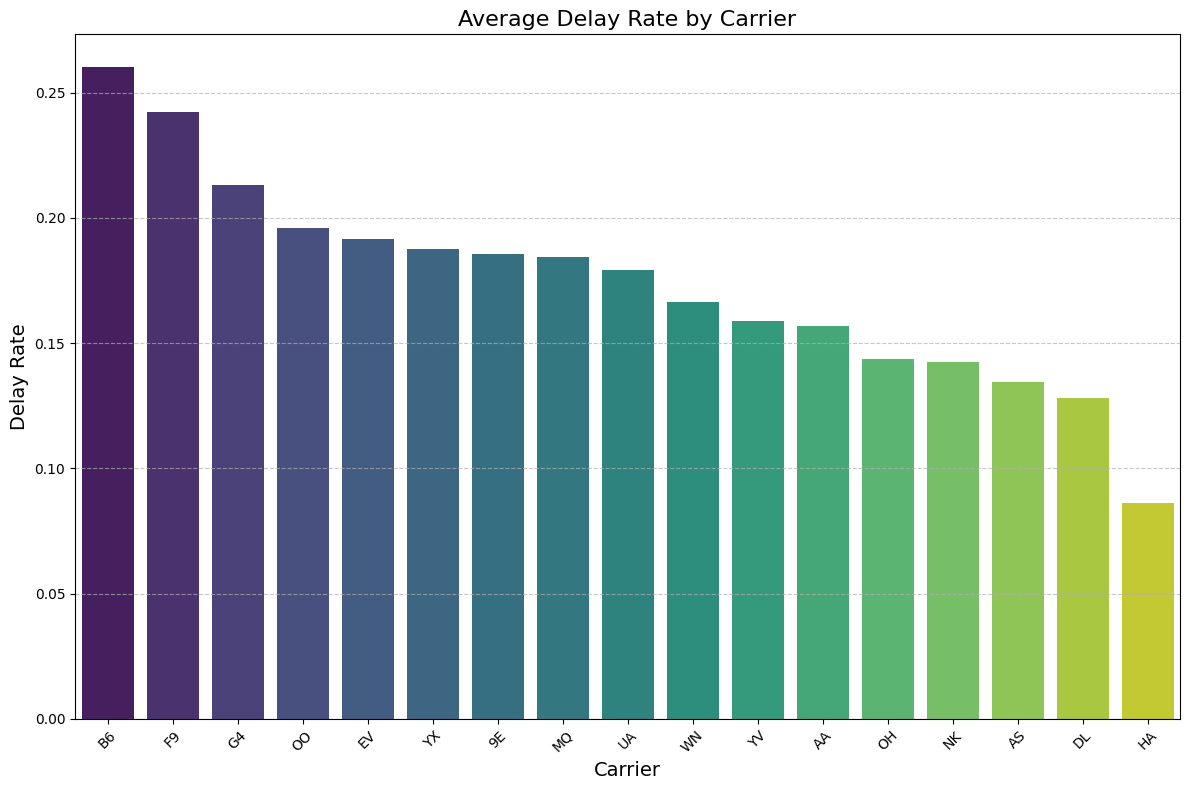

In [33]:
# Visualize carrier delay rates
plt.figure(figsize=(12, 8))
carrier_delay_df = pd.DataFrame({'Carrier': carrier_delay_rates.index, 'Delay Rate': carrier_delay_rates.values})
carrier_delay_df = carrier_delay_df.sort_values('Delay Rate', ascending=False)

sns.barplot(x='Carrier', y='Delay Rate', data=carrier_delay_df, palette='viridis')
plt.title('Average Delay Rate by Carrier', fontsize=16)
plt.xlabel('Carrier', fontsize=14)
plt.ylabel('Delay Rate', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
save_visualization(plt, '02_carrier_delay_rates')
plt.show()

Saved visualization: visualizations/03_day_of_week_delay_rates.png


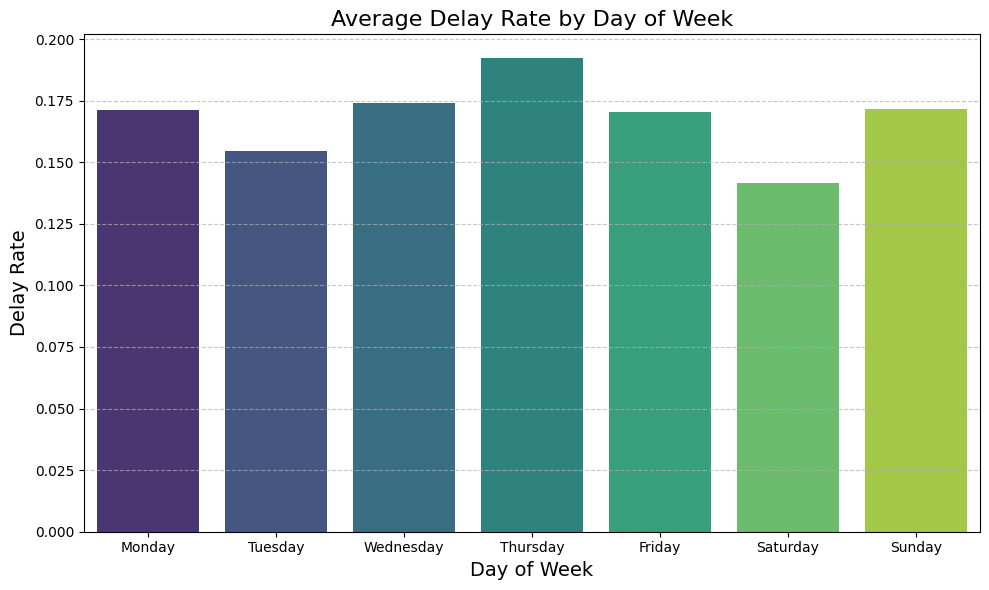

In [34]:
# Visualize delay rate by day of week
plt.figure(figsize=(10, 6))
days = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 
        5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
dow_delay_df = pd.DataFrame({
    'Day': [days[i] for i in dow_delay_rates.index],
    'Delay Rate': dow_delay_rates.values,
    'Day_num': dow_delay_rates.index
})
dow_delay_df = dow_delay_df.sort_values('Day_num')

sns.barplot(x='Day', y='Delay Rate', data=dow_delay_df, palette='viridis')
plt.title('Average Delay Rate by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Delay Rate', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
save_visualization(plt, '03_day_of_week_delay_rates')
plt.show()

In [35]:
print(f"Feature engineering completed in {time.time() - start_time:.2f} seconds")

Feature engineering completed in 2.16 seconds


In [36]:
# Feature Selection and Preparation for Modeling
print("\nPreparing data for modeling...")
start_time = time.time()


Preparing data for modeling...


In [37]:
# Define features and target
X = df_cleaned.drop('DEP_DEL15', axis=1)
y = df_cleaned['DEP_DEL15']

In [38]:
# Check class distribution
print("\nClass distribution in target variable:")
class_counts = y.value_counts()
print(class_counts)
print(f"Percentage of delayed flights: {class_counts[1.0]/len(y)*100:.2f}%")


Class distribution in target variable:
DEP_DEL15
0.0    485058
1.0     98927
Name: count, dtype: int64
Percentage of delayed flights: 16.94%


In [39]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()
print(f"Categorical features: {len(categorical_cols)}")
print(f"Numerical features: {len(numerical_cols)}")

Categorical features: 5
Numerical features: 24


In [40]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough')

In [41]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (467188, 29)
Test set shape: (116797, 29)


In [42]:
# Handle class imbalance using class weights
print("\nHandling class imbalance...")
# Calculate class weights inversely proportional to class frequencies
n_samples = len(y_train)
n_classes = len(np.unique(y_train))
# More weight to the minority class (delayed flights)
class_weight = {0.0: n_samples / (n_classes * np.sum(y_train == 0.0)),
                1.0: n_samples / (n_classes * np.sum(y_train == 1.0))}
print(f"Class weights: {class_weight}")


Handling class imbalance...
Class weights: {0.0: np.float64(0.6019750235796787), 1.0: np.float64(2.951580703040105)}


In [43]:
# Final check for NaN values before modeling
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [44]:
# Verify no NaN values in preprocessed data
if np.isnan(X_train_preprocessed).any() or np.isnan(X_test_preprocessed).any():
    print("Warning: There are still NaN values after preprocessing. Filling them with 0...")
    # Fill any remaining NaNs with 0
    X_train_preprocessed = np.nan_to_num(X_train_preprocessed)
    X_test_preprocessed = np.nan_to_num(X_test_preprocessed)

In [45]:
print(f"Data preparation completed in {time.time() - start_time:.2f} seconds")

Data preparation completed in 6.39 seconds


In [46]:
# Model Training and Evaluation
print("\nTraining models...")

# Function to evaluate model
def evaluate_model(model, X_train, X_test, y_train, y_test, preprocessor, model_name="Model"):
    start_time = time.time()
    
    # Create pipeline with preprocessor and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)
    
    print(f"Training time: {time.time() - start_time:.2f} seconds")
    print(f"Train accuracy: {train_score:.4f}")
    print(f"Test accuracy: {test_score:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Calculate and print balanced accuracy
    from sklearn.metrics import balanced_accuracy_score
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks([0.5, 1.5], ['No Delay (0)', 'Delay (1)'])
    plt.yticks([0.5, 1.5], ['No Delay (0)', 'Delay (1)'])
    save_visualization(plt, f'04_{model_name.lower().replace(" ", "_")}_confusion_matrix')
    plt.show()
    
    # Plot ROC curve
    if hasattr(pipeline, "predict_proba"):
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'ROC Curve - {model_name}', fontsize=14)
        plt.legend(loc="lower right", fontsize=12)
        plt.grid(linestyle='--', alpha=0.7)
        save_visualization(plt, f'05_{model_name.lower().replace(" ", "_")}_roc_curve')
        plt.show()
        
        # Plot Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2)
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.title(f'Precision-Recall Curve - {model_name}', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        save_visualization(plt, f'06_{model_name.lower().replace(" ", "_")}_precision_recall_curve')
        plt.show()
        
        # Plot actual vs predicted probabilities
        plt.figure(figsize=(10, 6))
        
        # Create a scatter plot of predicted probabilities
        colors = ['blue', 'red']
        cmap = ListedColormap(colors)
        
        plt.scatter(range(len(y_test)), y_prob, c=y_test, cmap=cmap, alpha=0.6, s=25)
        plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)
        plt.xlabel('Test Sample Index', fontsize=12)
        plt.ylabel('Predicted Probability of Delay', fontsize=12)
        plt.title(f'Actual vs Predicted Delay Probabilities - {model_name}\n(Blue = No Delay, Red = Delay)', fontsize=14)
        plt.ylim([-0.02, 1.02])
        plt.grid(True, alpha=0.3)
        save_visualization(plt, f'07_{model_name.lower().replace(" ", "_")}_prediction_probabilities')
        plt.show()
    
    return pipeline, test_score


Training models...



--- Random Forest Classifier ---
Training time: 178.53 seconds
Train accuracy: 1.0000
Test accuracy: 0.8712

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93     97012
         1.0       0.89      0.27      0.42     19785

    accuracy                           0.87    116797
   macro avg       0.88      0.63      0.67    116797
weighted avg       0.87      0.87      0.84    116797

Balanced Accuracy: 0.6333
Saved visualization: visualizations/04_random_forest_confusion_matrix.png


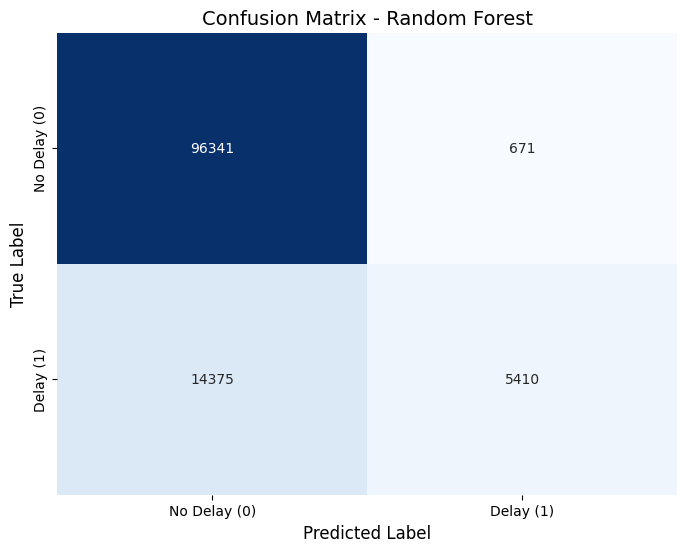

Saved visualization: visualizations/05_random_forest_roc_curve.png


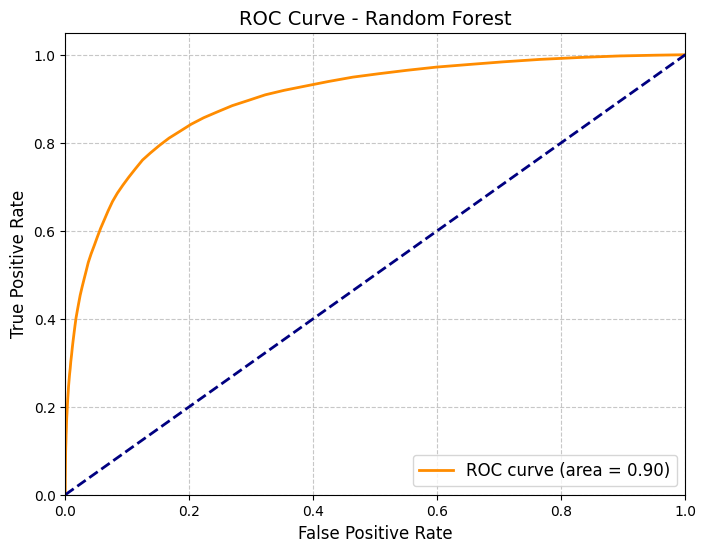

Saved visualization: visualizations/06_random_forest_precision_recall_curve.png


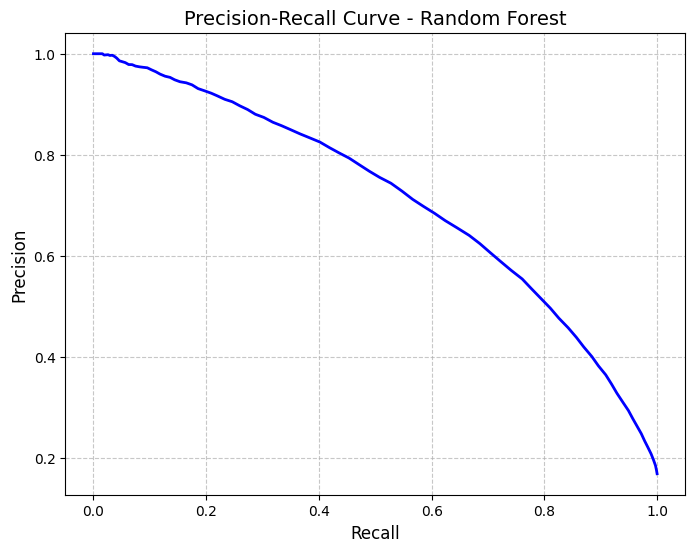

Saved visualization: visualizations/07_random_forest_prediction_probabilities.png


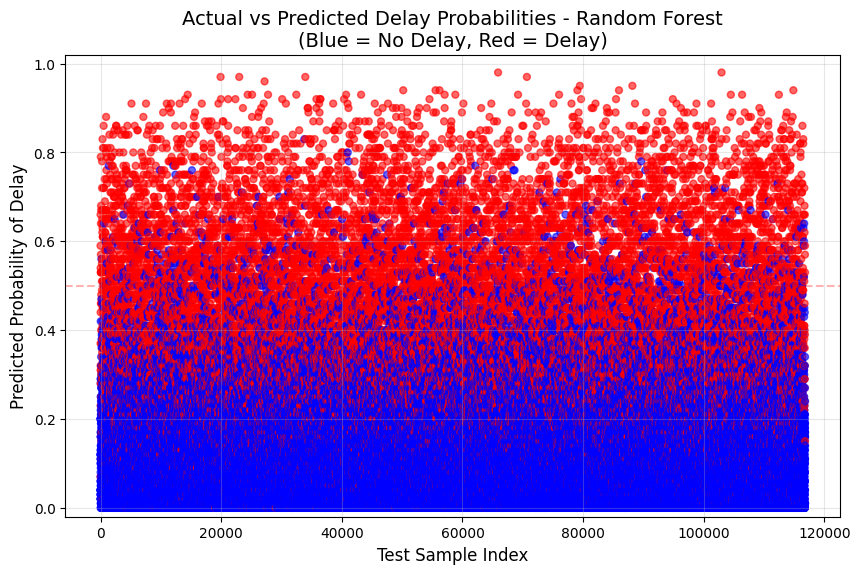

In [47]:
# 1. Random Forest Model
print("\n--- Random Forest Classifier ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight=class_weight)
rf_pipeline, rf_score = evaluate_model(rf_model, X_train, X_test, y_train, y_test, preprocessor, "Random Forest")


--- XGBoost Classifier ---
Training time: 30.69 seconds
Train accuracy: 0.9083
Test accuracy: 0.9022

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     97012
         1.0       0.68      0.81      0.74     19785

    accuracy                           0.90    116797
   macro avg       0.82      0.87      0.84    116797
weighted avg       0.91      0.90      0.91    116797

Balanced Accuracy: 0.8658
Saved visualization: visualizations/04_xgboost_confusion_matrix.png


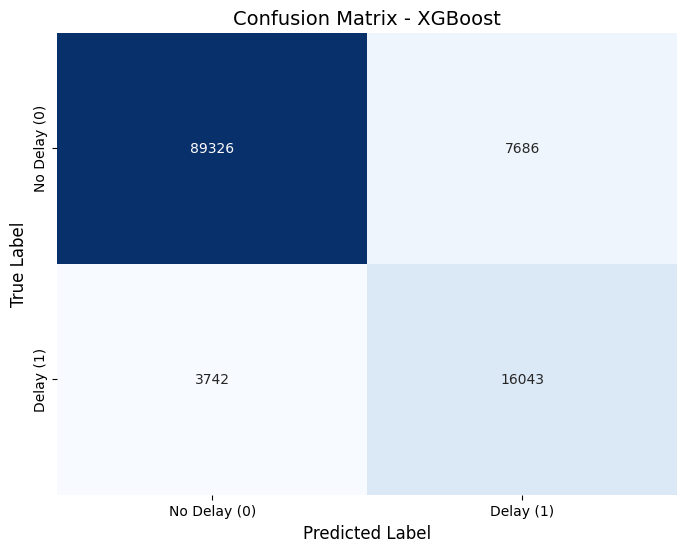

Saved visualization: visualizations/05_xgboost_roc_curve.png


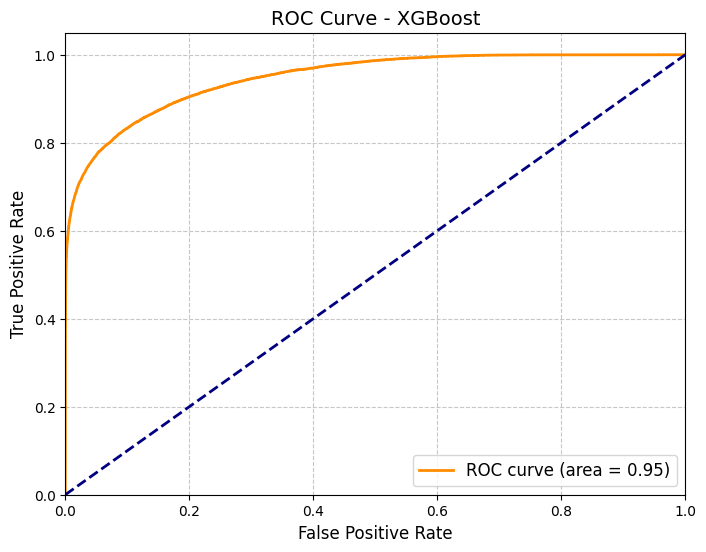

Saved visualization: visualizations/06_xgboost_precision_recall_curve.png


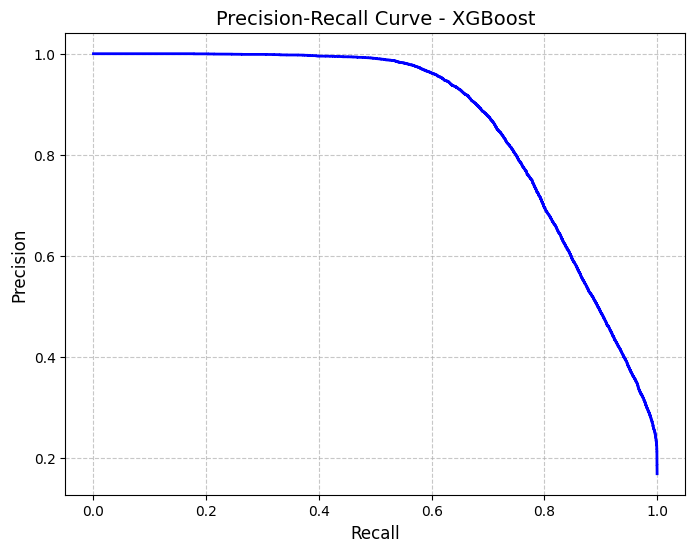

Saved visualization: visualizations/07_xgboost_prediction_probabilities.png


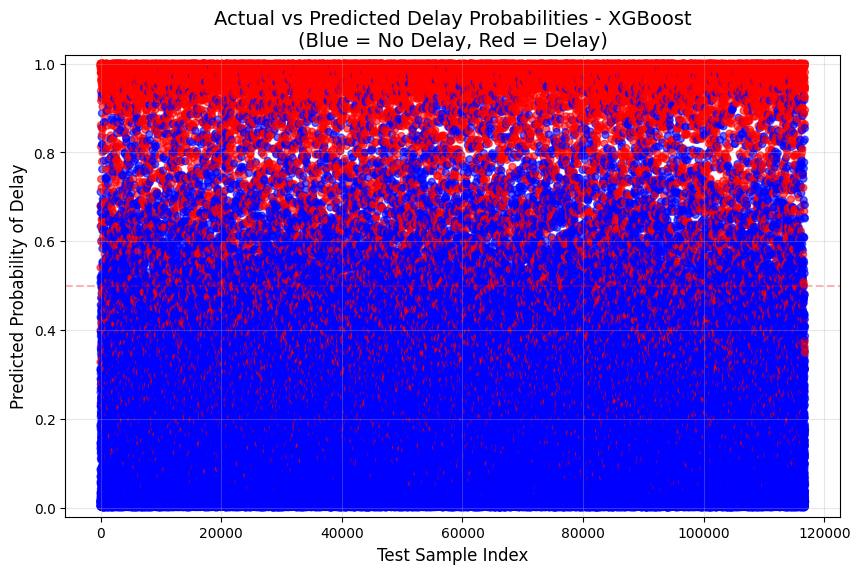

In [48]:
# 2. XGBoost Model
print("\n--- XGBoost Classifier ---")
# Set scale_pos_weight to handle class imbalance (ratio of negative to positive samples)
scale_pos_weight = np.sum(y_train == 0.0) / np.sum(y_train == 1.0)
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                             use_label_encoder=False, eval_metric='logloss',
                             scale_pos_weight=scale_pos_weight)
xgb_pipeline, xgb_score = evaluate_model(xgb_model, X_train, X_test, y_train, y_test, preprocessor, "XGBoost")

In [49]:
# 3. Logistic Regression (as a baseline)
print("\n--- Logistic Regression (Baseline) with PCA and SAGA solver ---")
# Create a pipeline with PCA for dimensionality reduction before logistic regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),  # Retain 95% of variance
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, 
                                     n_jobs=-1, class_weight=class_weight, 
                                     solver='saga', tol=1e-3))  # SAGA solver for large datasets
])


--- Logistic Regression (Baseline) with PCA and SAGA solver ---


In [50]:
start_time = time.time()
lr_pipeline.fit(X_train, y_train)
training_time = time.time() - start_time

In [51]:
# Make predictions
y_pred = lr_pipeline.predict(X_test)

In [52]:
# Calculate metrics
train_score = lr_pipeline.score(X_train, y_train)
test_score = lr_pipeline.score(X_test, y_test)

In [53]:
print(f"Training time: {training_time:.2f} seconds")
print(f"Train accuracy: {train_score:.4f}")
print(f"Test accuracy: {test_score:.4f}")

Training time: 15.61 seconds
Train accuracy: 0.6894
Test accuracy: 0.6857


In [54]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.68      0.78     97012
         1.0       0.31      0.71      0.43     19785

    accuracy                           0.69    116797
   macro avg       0.62      0.69      0.61    116797
weighted avg       0.82      0.69      0.72    116797



In [55]:
# Calculate and print balanced accuracy
from sklearn.metrics import balanced_accuracy_score
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_acc:.4f}")

Balanced Accuracy: 0.6938


Saved visualization: visualizations/08_logistic_regression_confusion_matrix.png


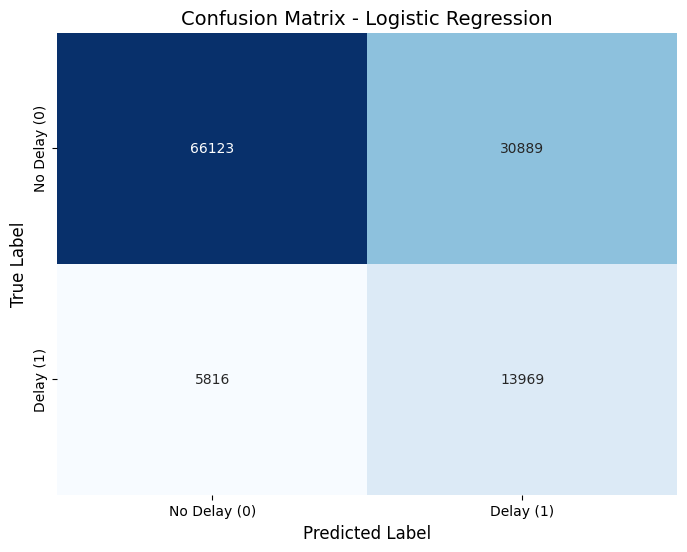

In [56]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks([0.5, 1.5], ['No Delay (0)', 'Delay (1)'])
plt.yticks([0.5, 1.5], ['No Delay (0)', 'Delay (1)'])
save_visualization(plt, '08_logistic_regression_confusion_matrix')
plt.show()

Saved visualization: visualizations/09_logistic_regression_roc_curve.png


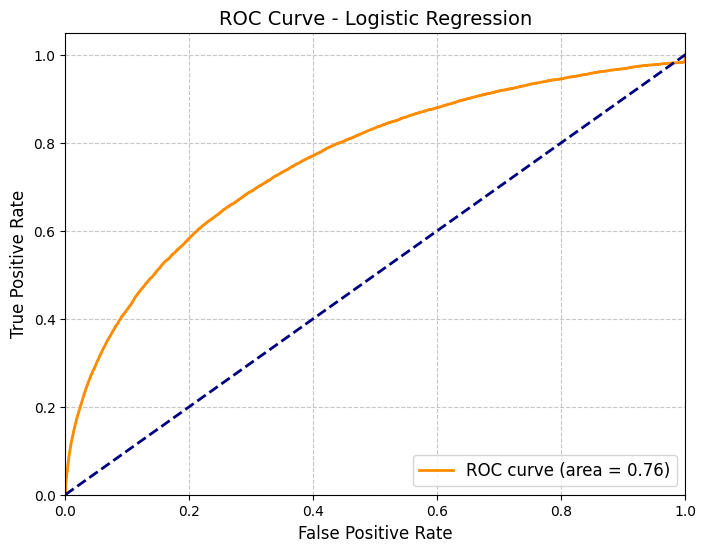

In [57]:
# Plot ROC curve
if hasattr(lr_pipeline, "predict_proba"):
    y_prob = lr_pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - Logistic Regression', fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(linestyle='--', alpha=0.7)
    save_visualization(plt, '09_logistic_regression_roc_curve')
    plt.show()

In [58]:
# Store score for comparison
lr_score = test_score

In [59]:
# Feature Importance Analysis
print("\nAnalyzing feature importance...")
start_time = time.time()


Analyzing feature importance...


In [60]:
# Extract feature names after one-hot encoding
preprocessor.fit(X_train)
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = np.append(numerical_cols, cat_features)

In [61]:
# Get feature importance from the Random Forest model
rf_model.fit(preprocessor.transform(X_train), y_train)
importances = rf_model.feature_importances_

In [62]:
# Sort feature importances
indices = np.argsort(importances)[::-1]

In [63]:
# Print top 20 features
print("Top 20 features by importance:")
for i in range(min(20, len(feature_names))):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

Top 20 features by importance:
1. DEP_TIME_MINUTES: 0.1760
2. DAY_OF_MONTH: 0.0477
3. DAY_OF_MONTH_SIN: 0.0470
4. OP_CARRIER_FL_NUM: 0.0435
5. DAY_OF_MONTH_COS: 0.0419
6. DISTANCE: 0.0364
7. DEP_HOUR: 0.0308
8. DEST_DELAY_RATE: 0.0304
9. ORIGIN_DELAY_RATE: 0.0294
10. DEP_HOUR_SIN: 0.0278
11. DEST_FREQUENCY: 0.0252
12. DEST_AIRPORT_SEQ_ID: 0.0242
13. DEST_AIRPORT_ID: 0.0242
14. ORIGIN_FREQUENCY: 0.0241
15. ORIGIN_AIRPORT_SEQ_ID: 0.0228
16. ORIGIN_AIRPORT_ID: 0.0226
17. DEP_HOUR_COS: 0.0219
18. DAY_OF_WEEK: 0.0213
19. DOW_DELAY_RATE: 0.0212
20. DAY_OF_WEEK_SIN: 0.0209


Saved visualization: visualizations/10_feature_importance_random_forest.png


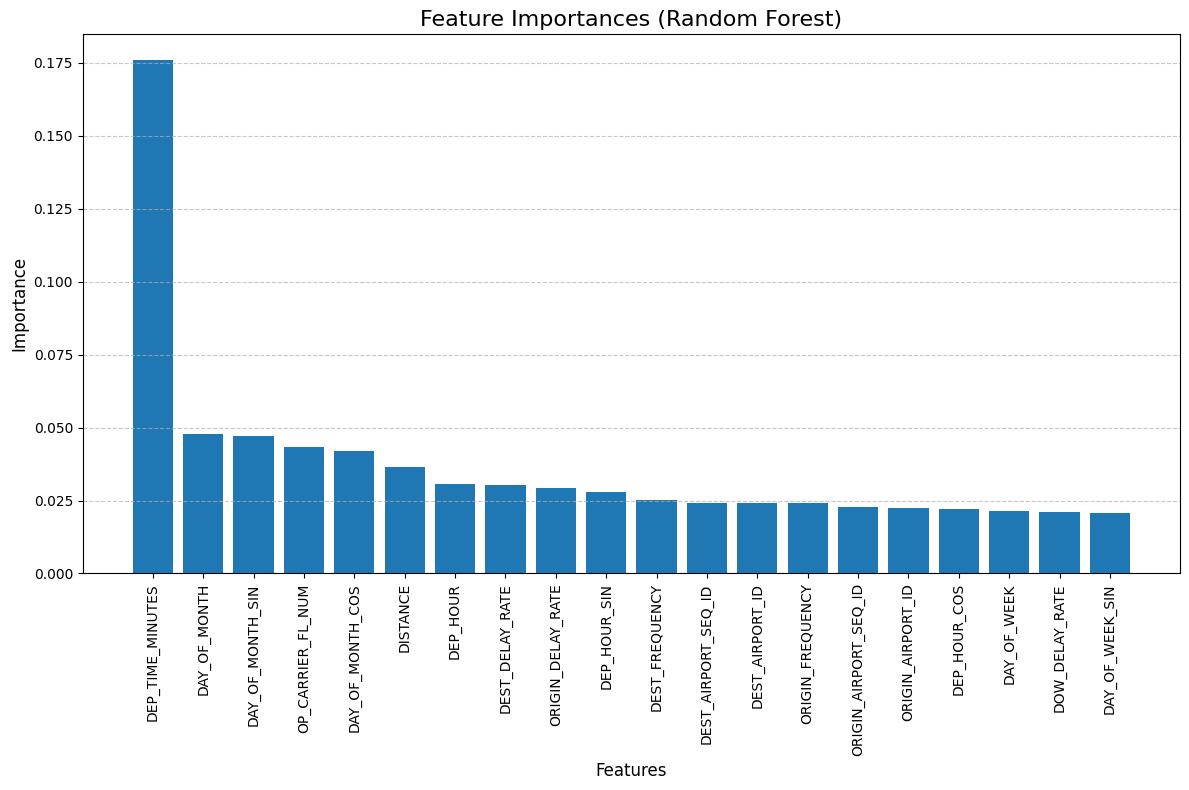

In [64]:
# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title('Feature Importances (Random Forest)', fontsize=16)
plt.bar(range(min(20, len(feature_names))), 
        importances[indices[:20]], 
        align='center')
plt.xticks(range(min(20, len(feature_names))), 
          [feature_names[i] for i in indices[:20]], 
          rotation=90)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
save_visualization(plt, '10_feature_importance_random_forest')
plt.show()

In [65]:
# SHAP analysis for deeper feature importance understanding
print("\nPerforming SHAP analysis for more detailed feature importance...")


Performing SHAP analysis for more detailed feature importance...


In [66]:
# Transform a sample of training data for SHAP analysis
# Using a small sample to speed up computation
sample_size = min(500, len(X_train))  # Reduced sample size
X_train_sample = X_train.sample(sample_size, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]  # Get corresponding target values
X_train_transformed = preprocessor.transform(X_train_sample)

In [67]:
# Get top features based on Random Forest importance
n_top_features = 15  # Limit to top 15 features
feature_indices = np.argsort(importances)[::-1][:n_top_features]
top_feature_names = [feature_names[i] for i in feature_indices]

In [68]:
# Filter transformed data to include only top features
X_train_transformed_top = X_train_transformed[:, feature_indices]

In [69]:
print(f"Running SHAP analysis on top {n_top_features} features...")
print(f"Top features: {', '.join(top_feature_names[:5])}...")

Running SHAP analysis on top 15 features...
Top features: DEP_TIME_MINUTES, DAY_OF_MONTH, DAY_OF_MONTH_SIN, OP_CARRIER_FL_NUM, DAY_OF_MONTH_COS...


In [70]:
# Create a simplified Random Forest model for faster SHAP computation
simple_rf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
simple_rf.fit(X_train_transformed_top, y_train_sample.values)

RandomForestClassifier(max_depth=5, n_estimators=50, random_state=42)

In [71]:
# Create SHAP explainer with the simplified model and top features
explainer = shap.TreeExplainer(simple_rf)
shap_values = explainer.shap_values(X_train_transformed_top)

In [72]:
# Check the shape of shap_values to handle different SHAP return formats
print(f"SHAP values shape: {np.array(shap_values).shape}")

SHAP values shape: (500, 15, 2)


Saved visualization: visualizations/11_shap_values_summary.png


<Figure size 1200x800 with 0 Axes>

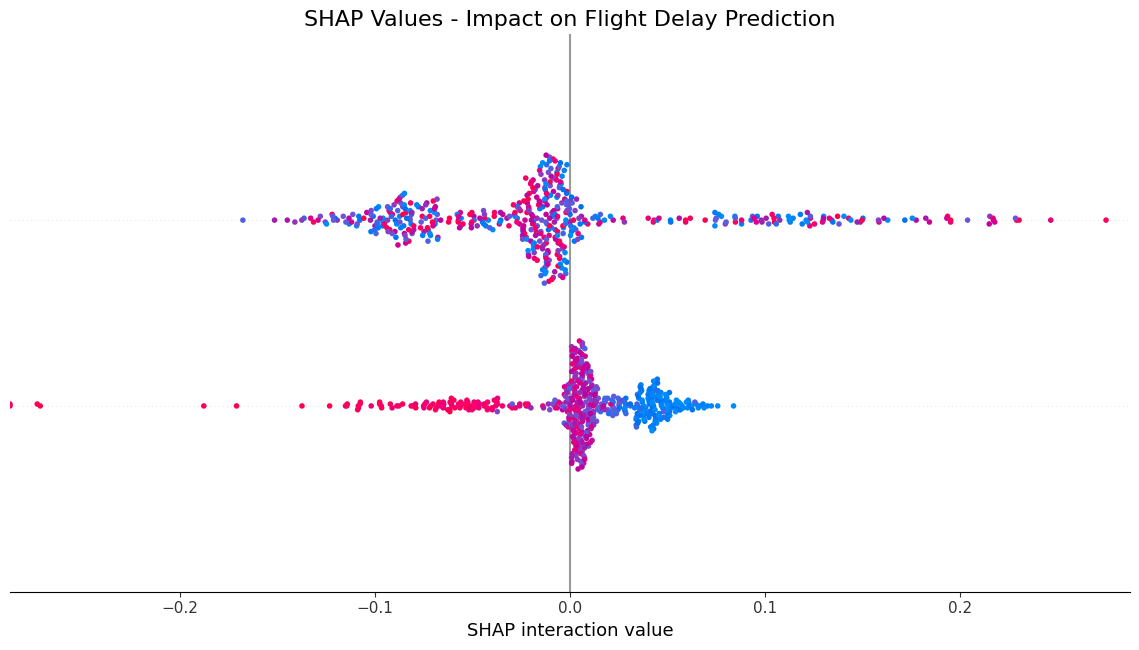

In [73]:
# Summary plot with top features - handling different SHAP output formats
plt.figure(figsize=(12, 8))
try:
    # If shap_values is a list of arrays (one per class)
    if isinstance(shap_values, list):
        # For binary classification, we typically want the positive class (index 1)
        if len(shap_values) > 1:
            # Binary classification case
            shap.summary_plot(shap_values[1], X_train_transformed_top, 
                             feature_names=top_feature_names, show=False)
        else:
            # Single array case
            shap.summary_plot(shap_values[0], X_train_transformed_top, 
                             feature_names=top_feature_names, show=False)
    else:
        # If it's a single array
        shap.summary_plot(shap_values, X_train_transformed_top, 
                         feature_names=top_feature_names, show=False)
        
    plt.title('SHAP Values - Impact on Flight Delay Prediction', fontsize=16)
    plt.tight_layout()
    save_visualization(plt, '11_shap_values_summary')
    plt.show()
except Exception as e:
    print(f"Error in SHAP summary plot: {e}")
    # Fall back to alternative visualization
    plt.close()
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_feature_names)), importances[feature_indices])
    plt.yticks(range(len(top_feature_names)), top_feature_names)
    plt.title('Feature Importance (Random Forest)', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    save_visualization(plt, '12_feature_importance_alternative')
    plt.show()

Saved visualization: visualizations/13_top_features_importance.png


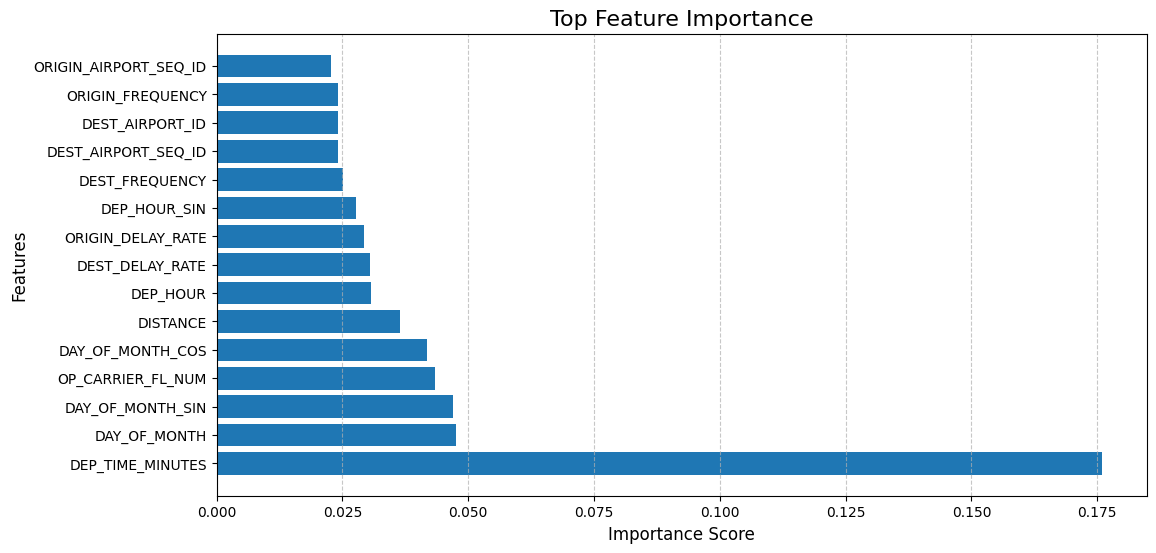

In [74]:
# Bar plot of feature importance using Random Forest importance instead if SHAP fails
plt.figure(figsize=(12, 6))
plt.barh(range(len(top_feature_names)), importances[feature_indices])
plt.yticks(range(len(top_feature_names)), top_feature_names)
plt.title('Top Feature Importance', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
save_visualization(plt, '13_top_features_importance')
plt.show()

In [75]:
print(f"Feature importance analysis completed in {time.time() - start_time:.2f} seconds")

Feature importance analysis completed in 99.74 seconds


In [76]:
# Dimension Reduction with PCA
print("\nEvaluating dimension reduction with PCA...")
start_time = time.time()


Evaluating dimension reduction with PCA...


In [77]:
# Get preprocessed data
X_train_preprocessed = preprocessor.transform(X_train)

In [78]:
# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_preprocessed)
X_test_pca = pca.transform(preprocessor.transform(X_test))

In [79]:
print(f"Original number of features: {X_train_preprocessed.shape[1]}")
print(f"Number of features after PCA: {X_train_pca.shape[1]}")
print(f"Variance explained by components: {pca.explained_variance_ratio_.sum():.4f}")

Original number of features: 769
Number of features after PCA: 59
Variance explained by components: 0.9507


Saved visualization: visualizations/14_pca_explained_variance.png


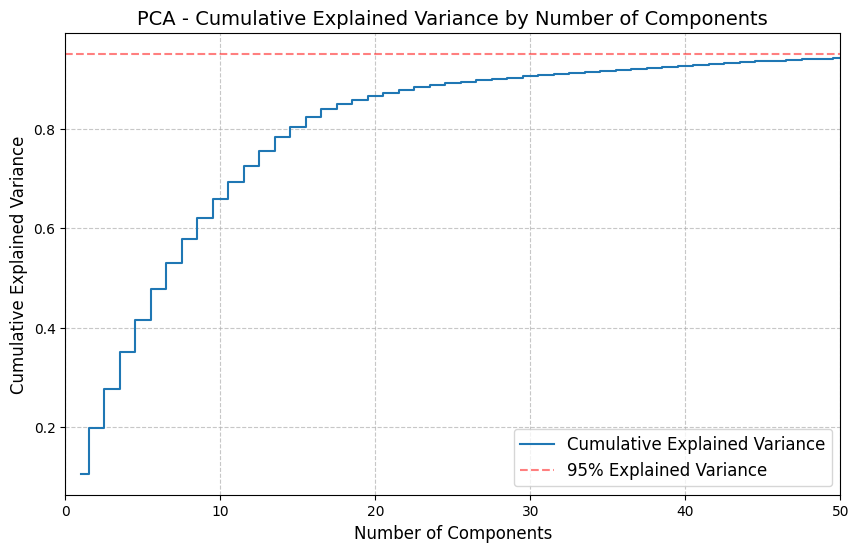

In [80]:
# Visualize explained variance by components
plt.figure(figsize=(10, 6))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', 
         label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.5, label='95% Explained Variance')
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('PCA - Cumulative Explained Variance by Number of Components', fontsize=14)
plt.xlim(0, min(50, len(cumulative_variance)))  # Limit x-axis for better visualization
plt.grid(linestyle='--', alpha=0.7)
plt.legend(loc='best', fontsize=12)
save_visualization(plt, '14_pca_explained_variance')
plt.show()

In [81]:
# Train and evaluate a model with PCA
print("\n--- Random Forest with PCA ---")
rf_model_pca = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight=class_weight)
rf_model_pca.fit(X_train_pca, y_train)
y_pred_pca = rf_model_pca.predict(X_test_pca)


--- Random Forest with PCA ---


In [82]:
# Calculate metrics
pca_accuracy = rf_model_pca.score(X_test_pca, y_test)
print(f"PCA model accuracy: {pca_accuracy:.4f}")
print("\nClassification Report (PCA model):")
print(classification_report(y_test, y_pred_pca))

PCA model accuracy: 0.9407

Classification Report (PCA model):
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97     97012
         1.0       0.96      0.68      0.80     19785

    accuracy                           0.94    116797
   macro avg       0.95      0.84      0.88    116797
weighted avg       0.94      0.94      0.94    116797



Saved visualization: visualizations/15_random_forest_pca_confusion_matrix.png


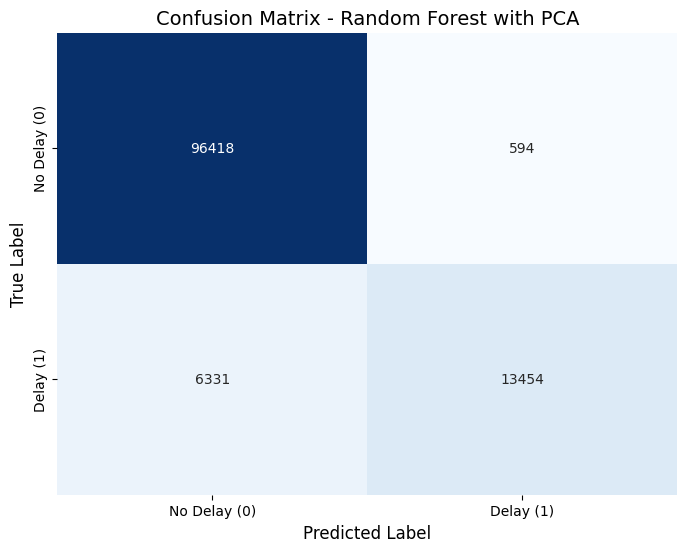

In [83]:
# Plot confusion matrix for PCA model
cm_pca = confusion_matrix(y_test, y_pred_pca)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest with PCA', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks([0.5, 1.5], ['No Delay (0)', 'Delay (1)'])
plt.yticks([0.5, 1.5], ['No Delay (0)', 'Delay (1)'])
save_visualization(plt, '15_random_forest_pca_confusion_matrix')
plt.show()

In [84]:
print(f"PCA analysis completed in {time.time() - start_time:.2f} seconds")

PCA analysis completed in 180.17 seconds


In [85]:
# Model Optimization
print("\nOptimizing best model...")
start_time = time.time()


Optimizing best model...


In [86]:
# Choose the best model based on performance
best_scores = {'Random Forest': rf_score, 'XGBoost': xgb_score, 'Logistic Regression': lr_score}
best_model_name = max(best_scores, key=best_scores.get)
print(f"Best model based on test accuracy: {best_model_name} ({best_scores[best_model_name]:.4f})")

Best model based on test accuracy: XGBoost (0.9022)


In [87]:
# Parameter tuning for the best model
if best_model_name == 'Random Forest':
    model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight=class_weight)
    param_grid = {
        'model__n_estimators': [50, 100],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    }
elif best_model_name == 'XGBoost':
    model = xgb.XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, 
                             eval_metric='logloss', scale_pos_weight=scale_pos_weight)
    param_grid = {
        'model__n_estimators': [50, 100],
        'model__max_depth': [3, 6],
        'model__learning_rate': [0.01, 0.1],
        'model__subsample': [0.8, 1.0]
    }
else:  # Logistic Regression
    model = LogisticRegression(random_state=42, n_jobs=-1, class_weight=class_weight)
    param_grid = {
        'model__C': [0.1, 1.0, 10.0],
        'model__penalty': ['l2'],
        'model__solver': ['lbfgs', 'liblinear']
    }

In [88]:
# Create a pipeline for grid search
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

In [89]:
# Perform grid search - use a smaller CV to reduce computation time
print("Starting grid search with reduced parameters to save time...")
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Starting grid search with reduced parameters to save time...


/Users/alibaalam/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:40:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/alibaalam/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:40:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/alibaalam/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:40:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/alibaalam/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:40:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 100, 'model__subsample': 1.0}
Best cross-validation score: 0.9017


In [90]:
# Evaluate optimized model
best_pipeline = grid_search.best_estimator_
y_pred_optimized = best_pipeline.predict(X_test)
optimized_score = best_pipeline.score(X_test, y_test)

print(f"Optimized model accuracy: {optimized_score:.4f}")
print("\nClassification Report (Optimized model):")
print(classification_report(y_test, y_pred_optimized))

Optimized model accuracy: 0.8989

Classification Report (Optimized model):
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     97012
         1.0       0.67      0.79      0.73     19785

    accuracy                           0.90    116797
   macro avg       0.81      0.86      0.83    116797
weighted avg       0.91      0.90      0.90    116797



Saved visualization: visualizations/16_optimized_model_confusion_matrix.png


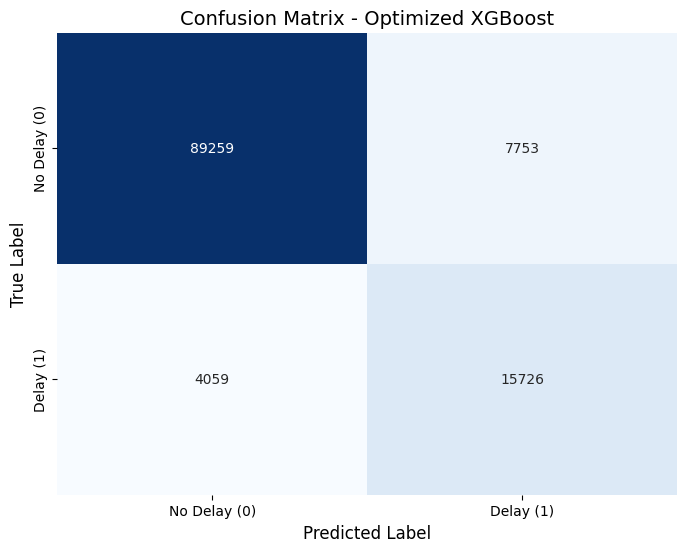

In [91]:
# Create confusion matrix for the optimized model
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - Optimized {best_model_name}', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks([0.5, 1.5], ['No Delay (0)', 'Delay (1)'])
plt.yticks([0.5, 1.5], ['No Delay (0)', 'Delay (1)'])
save_visualization(plt, '16_optimized_model_confusion_matrix')
plt.show()

In [92]:
print(f"Model optimization completed in {time.time() - start_time:.2f} seconds")

Model optimization completed in 1050.04 seconds


In [93]:
# Final Model and Conclusion
print("\nFinal model summary:")
print(f"Model: {best_model_name}")
print(f"Accuracy: {optimized_score:.4f}")


Final model summary:
Model: XGBoost
Accuracy: 0.8989


Saved visualization: visualizations/17_final_model_prediction_probabilities.png


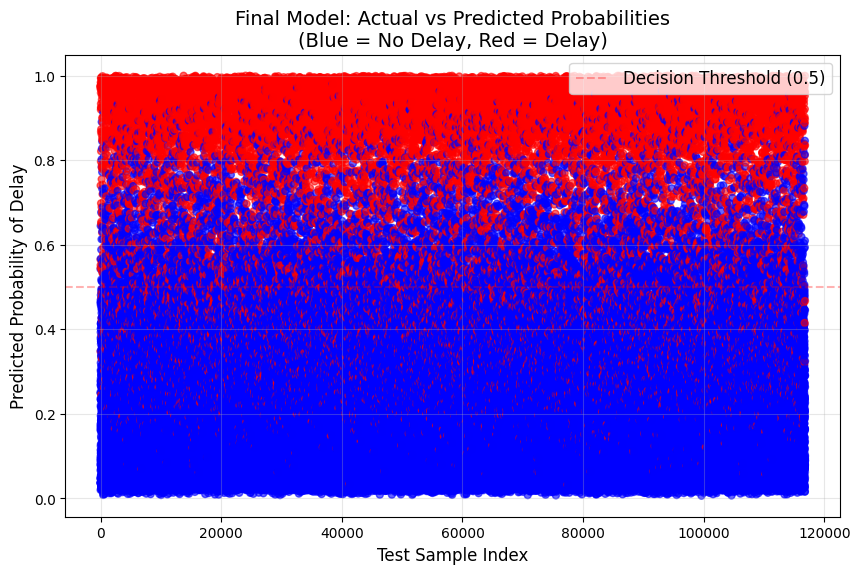

Saved visualization: visualizations/18_final_model_roc_curve.png


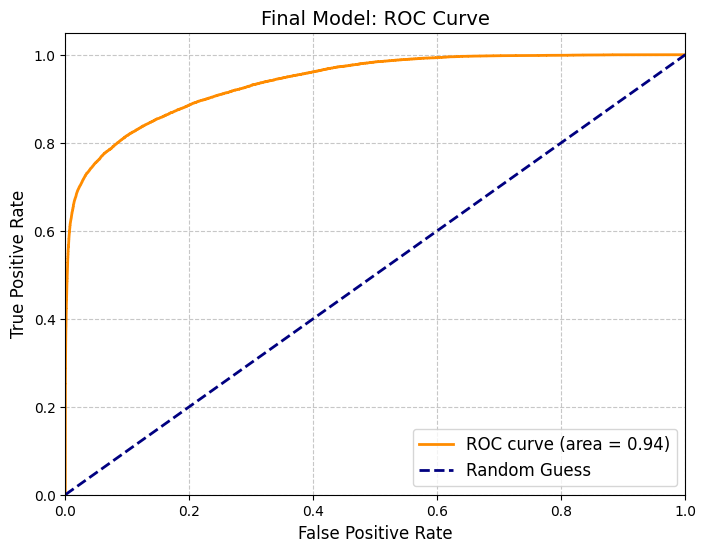

Saved visualization: visualizations/19_final_model_precision_recall_curve.png


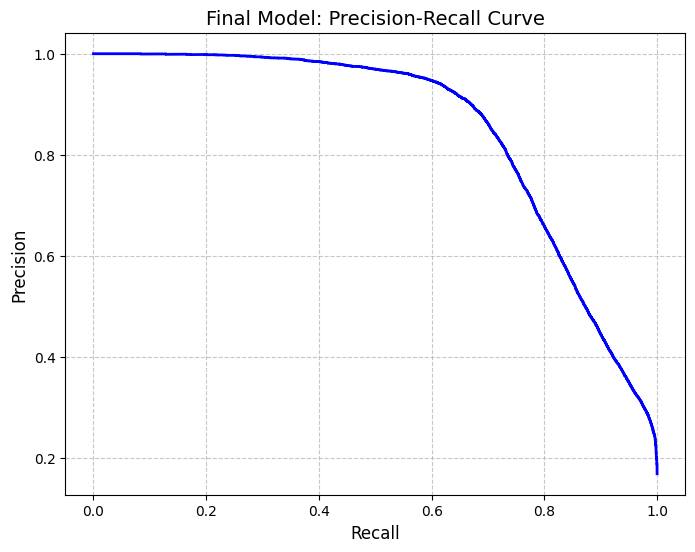

In [94]:
# Generate predictions for visualization
if hasattr(best_pipeline, "predict_proba"):
    y_proba = best_pipeline.predict_proba(X_test)[:, 1]
    
    # Plot actual vs predicted probabilities
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_test)), y_proba, c=y_test, 
                cmap=ListedColormap(['blue', 'red']), alpha=0.6, s=25)
    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3, label='Decision Threshold (0.5)')
    plt.xlabel('Test Sample Index', fontsize=12)
    plt.ylabel('Predicted Probability of Delay', fontsize=12)
    plt.title(f'Final Model: Actual vs Predicted Probabilities\n(Blue = No Delay, Red = Delay)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    save_visualization(plt, '17_final_model_prediction_probabilities')
    plt.show()
    
    # Plot ROC curve for the final model
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'Final Model: ROC Curve', fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(linestyle='--', alpha=0.7)
    save_visualization(plt, '18_final_model_roc_curve')
    plt.show()

    # Plot Precision-Recall curve for the final model
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Final Model: Precision-Recall Curve', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    save_visualization(plt, '19_final_model_precision_recall_curve')
    plt.show()

In [95]:
# Create a model comparison visualization
plt.figure(figsize=(10, 6))
model_names = list(best_scores.keys())
model_scores = [best_scores[model] for model in model_names]
model_colors = ['#3498db', '#2ecc71', '#e74c3c']  # Blue, Green, Red

<Figure size 1000x600 with 0 Axes>

In [96]:
# Add the optimized model score
model_names.append(f'Optimized {best_model_name}')
model_scores.append(optimized_score)
model_colors.append('#9b59b6')  # Purple for optimized model

In [97]:
# Sort by scores for better visualization
sorted_indices = np.argsort(model_scores)
sorted_model_names = [model_names[i] for i in sorted_indices]
sorted_model_scores = [model_scores[i] for i in sorted_indices]
sorted_model_colors = [model_colors[i] for i in sorted_indices]

(0.635736791184705, 0.9521550211049942)

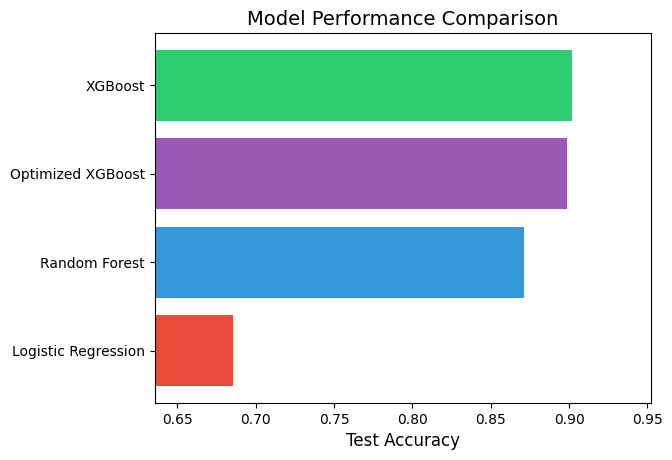

In [98]:
plt.barh(sorted_model_names, sorted_model_scores, color=sorted_model_colors)
plt.xlabel('Test Accuracy', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14)
plt.xlim([min(sorted_model_scores) - 0.05, max(sorted_model_scores) + 0.05])

Saved visualization: visualizations/20_model_comparison.png


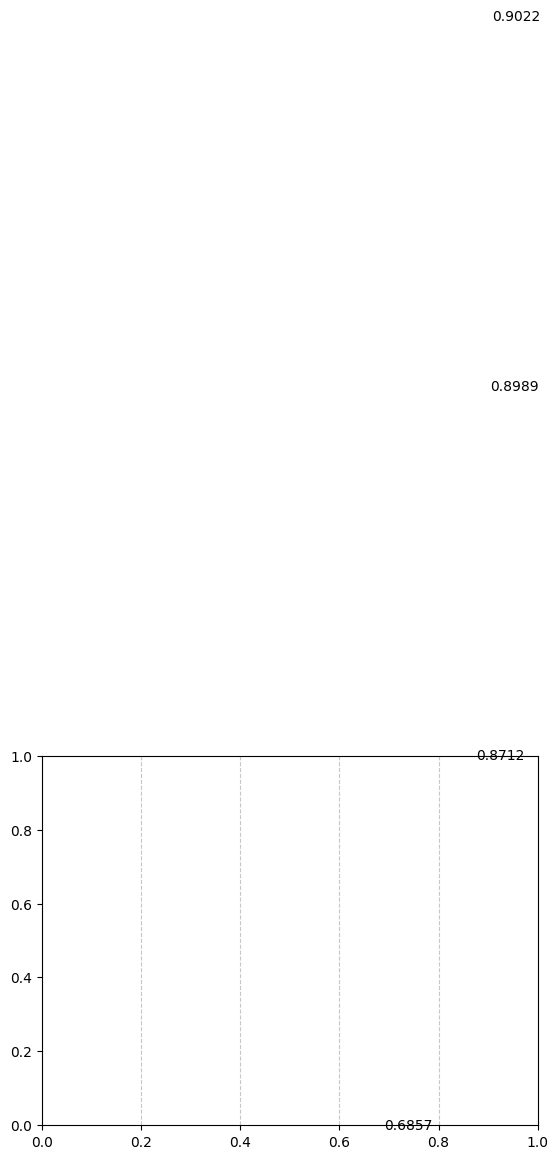

In [99]:
# Add accuracy values at the end of each bar
for i, score in enumerate(sorted_model_scores):
    plt.text(score + 0.005, i, f'{score:.4f}', va='center', fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.7)
save_visualization(plt, '20_model_comparison')
plt.show()

Saved visualization: visualizations/21_flight_delays_by_carrier.png


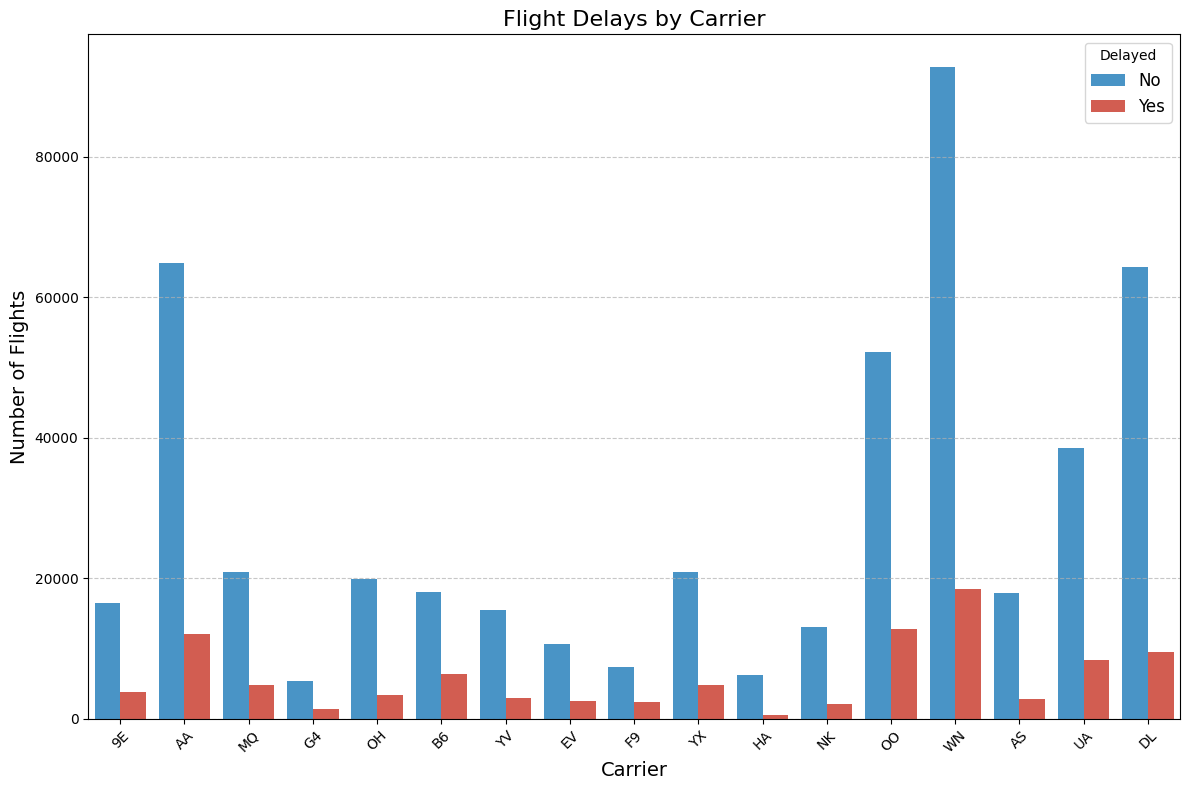

In [100]:
# Visualize carrier performance
plt.figure(figsize=(12, 8))
sns.countplot(x='OP_CARRIER', hue='DEP_DEL15', data=df_cleaned, palette=['#3498db', '#e74c3c'])
plt.title('Flight Delays by Carrier', fontsize=16)
plt.xlabel('Carrier', fontsize=14)
plt.ylabel('Number of Flights', fontsize=14)
plt.legend(title='Delayed', labels=['No', 'Yes'], fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
save_visualization(plt, '21_flight_delays_by_carrier')
plt.show()

Saved visualization: visualizations/22_flight_delays_by_day.png


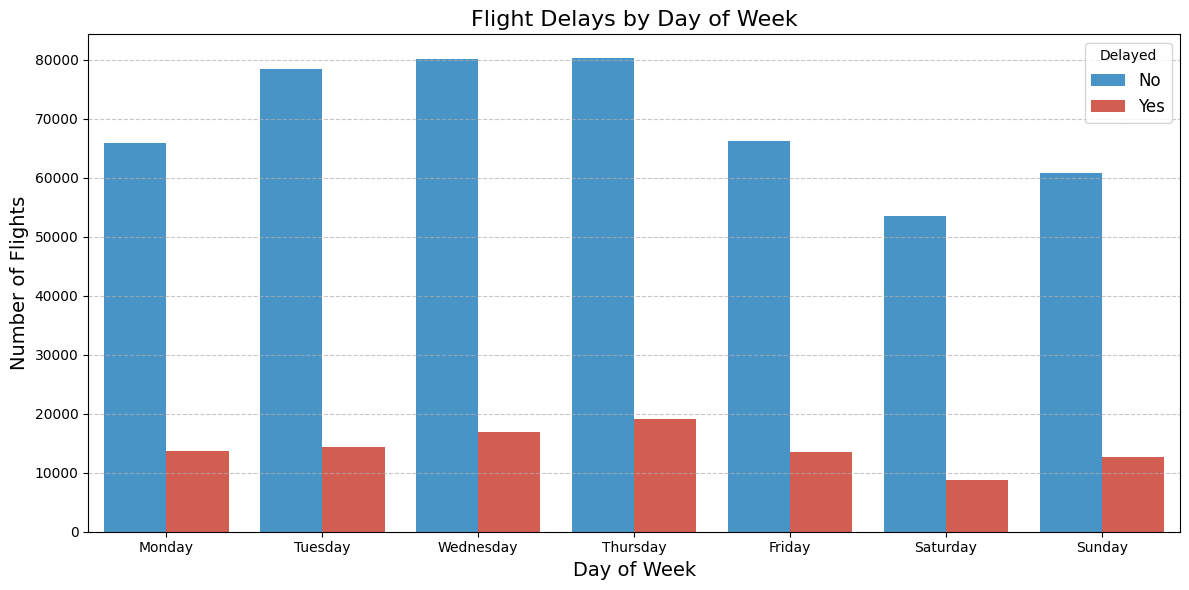

In [101]:
# Visualize day of week performance
if 'DAY_OF_WEEK' in df_cleaned.columns:
    days_dict = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 
                5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
    df_cleaned['DAY_NAME'] = df_cleaned['DAY_OF_WEEK'].map(days_dict)
    
    plt.figure(figsize=(12, 6))
    sns.countplot(x='DAY_NAME', hue='DEP_DEL15', data=df_cleaned, 
                  order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                  palette=['#3498db', '#e74c3c'])
    plt.title('Flight Delays by Day of Week', fontsize=16)
    plt.xlabel('Day of Week', fontsize=14)
    plt.ylabel('Number of Flights', fontsize=14)
    plt.legend(title='Delayed', labels=['No', 'Yes'], fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    save_visualization(plt, '22_flight_delays_by_day')
    plt.show()

In [102]:
print("\nProject execution completed successfully!")
print(f"All visualizations saved to directory: {viz_dir}")


Project execution completed successfully!
All visualizations saved to directory: visualizations
